# GRAPE calculation of control fields for cnot implementation

[This is an updated implementation based on the deprecated notebook of GRAPE CNOT implementation by Robert Johansson](https://nbviewer.org/github/qutip/qutip-notebooks/blob/master/examples/control-grape-cnot.ipynb)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
# the library for quantum control
import qutip_qtrl.pulseoptim as cpo

In [2]:
# total duration
T = 2 * np.pi
# number of time steps
times = np.linspace(0, T, 500)

In [3]:
U_0 = qt.operators.identity(4)
U_target = qt.core.gates.cnot()

### Starting Point

In [4]:
U_0

Quantum object: dims=[[4], [4]], shape=(4, 4), type='oper', dtype=Dia, isherm=True
Qobj data =
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]

### Target Operator

In [5]:
U_target

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]

In [6]:
# Drift Hamiltonian
g = 0
H_drift = g * (
    qt.tensor(qt.sigmax(), qt.sigmax()) + qt.tensor(qt.sigmay(), qt.sigmay())
)

In [7]:
H_ctrl = [
    qt.tensor(qt.sigmax(), qt.identity(2)),
    qt.tensor(qt.sigmay(), qt.identity(2)),
    qt.tensor(qt.sigmaz(), qt.identity(2)),
    qt.tensor(qt.identity(2), qt.sigmax()),
    qt.tensor(qt.identity(2), qt.sigmay()),
    qt.tensor(qt.identity(2), qt.sigmaz()),
    qt.tensor(qt.sigmax(), qt.sigmax()),
    qt.tensor(qt.sigmay(), qt.sigmay()),
    qt.tensor(qt.sigmaz(), qt.sigmaz()),
]

In [8]:
H_labels = [
    r"$u_{1x}$",
    r"$u_{1y}$",
    r"$u_{1z}$",
    r"$u_{2x}$",
    r"$u_{2y}$",
    r"$u_{2z}$",
    r"$u_{xx}$",
    r"$u_{yy}$",
    r"$u_{zz}$",
]

## GRAPE

In [9]:
result = cpo.optimize_pulse_unitary(
    H_drift,
    H_ctrl,
    U_0,
    U_target,
    num_tslots=500,
    evo_time=(2 * np.pi),
    # this attribute is crucial for convergence!!
    amp_lbound=-(2 * np.pi * 0.05),
    amp_ubound=(2 * np.pi * 0.05),
    fid_err_targ=1e-9,
    max_iter=500,
    max_wall_time=60,
    alg="GRAPE",
    optim_method="FMIN_L_BFGS_B",
    method_params={
        "disp": True,
        "maxiter": 1000,
    },
)

In [10]:
for attr in dir(result):
    if not attr.startswith("_"):
        print(f"{attr}: {getattr(result, attr)}")

print(np.shape(result.final_amps))

evo_full_final: Quantum object: dims=[[4], [4]], shape=(4, 4), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 7.07105503e-01+7.07108059e-01j  4.83742967e-06+1.14963251e-06j
  -4.29972488e-06-3.98558590e-08j  6.06767829e-06-9.06302521e-06j]
 [-1.14964236e-06-4.83753110e-06j  7.07102230e-01+7.07111333e-01j
   5.56808023e-06+1.04985158e-06j  8.93549090e-06-7.71916463e-06j]
 [ 9.06299792e-06-6.06765124e-06j  7.71919410e-06-8.93550526e-06j
   5.63681772e-06-3.25521625e-06j  7.07107875e-01+7.07105687e-01j]
 [ 3.98133994e-08+4.29970422e-06j -1.04991082e-06-5.56809536e-06j
   7.07111517e-01+7.07102045e-01j  3.25514921e-06-5.63684652e-06j]]
evo_full_initial: Quantum object: dims=[[4], [4]], shape=(4, 4), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 9.98195650e-01+0.03357417j  1.50020592e-02+0.04004484j
   1.35742682e-03-0.0230611j  -2.04651807e-03-0.01056996j]
 [-1.64872826e-02+0.03981692j  9.97014739e-01-0.03093676j
   3.96734825e-03-0.05338581j  3.61740685e-03-0.01638414j]
 [ 

## Plot control fields for cnot gate in the presense of single-qubit tunnelling

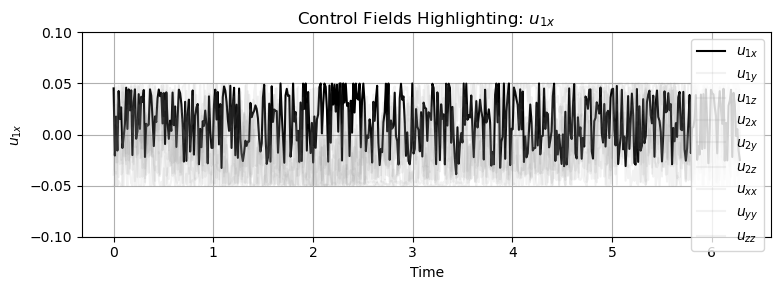

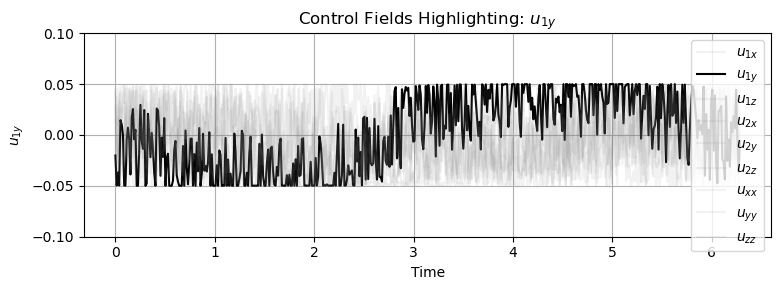

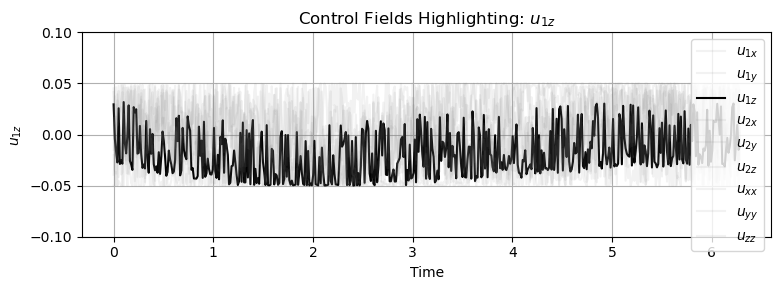

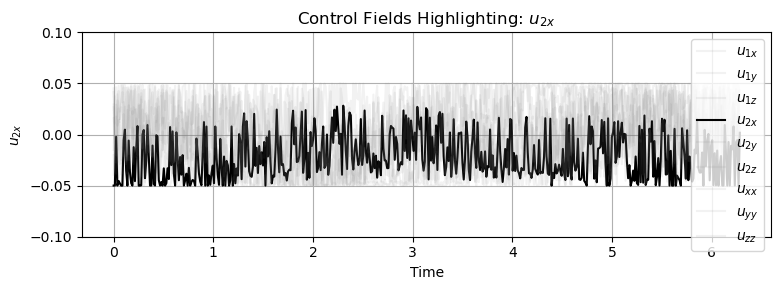

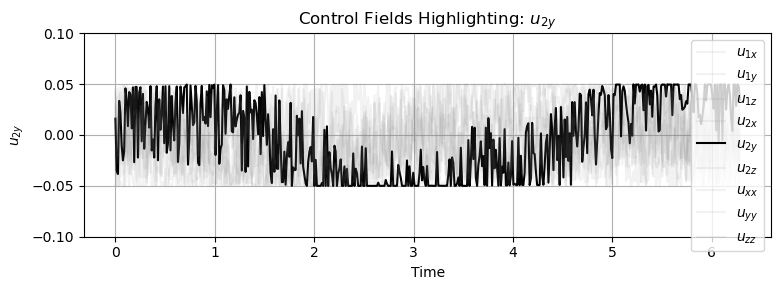

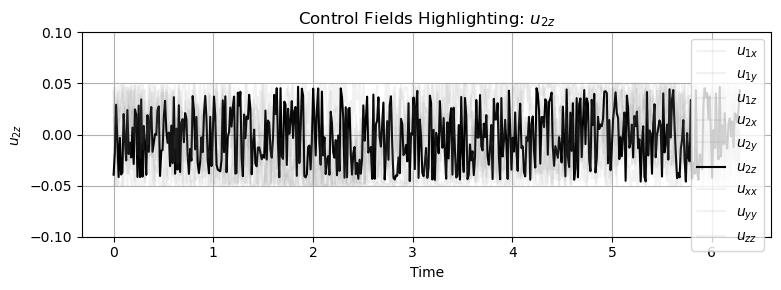

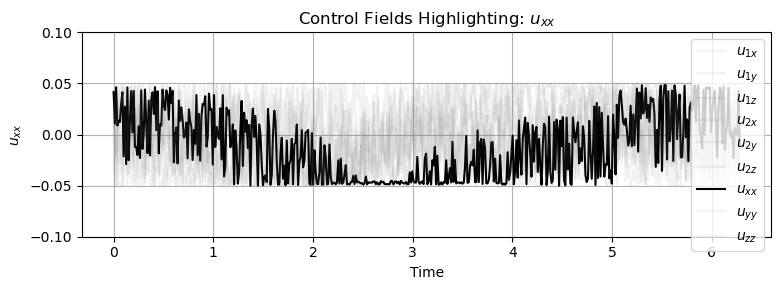

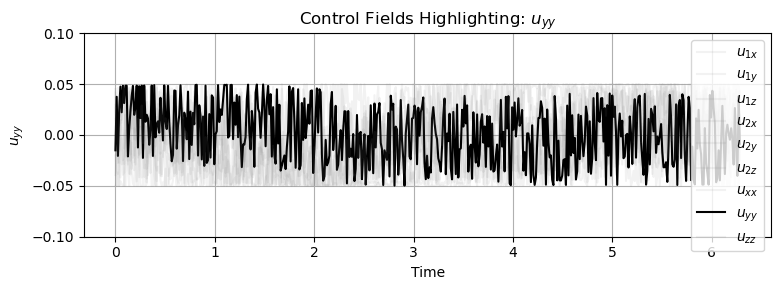

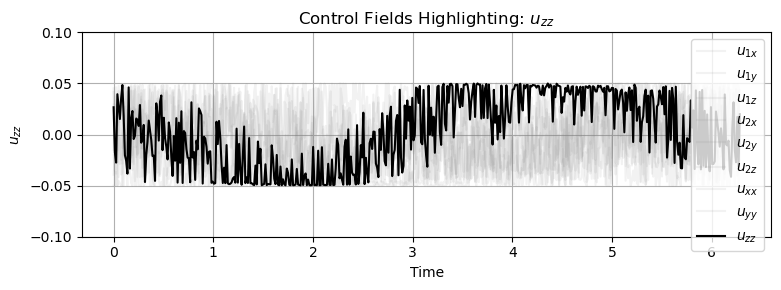

In [11]:
def plot_control_amplitudes(times, final_amps, labels):
    num_controls = final_amps.shape[1]

    y_max = 0.1  # Fixed y-axis scale
    y_min = -0.1

    for i in range(num_controls):
        fig, ax = plt.subplots(figsize=(8, 3))

        for j in range(num_controls):
            # Highlight the current control
            color = "black" if i == j else "gray"
            alpha = 1.0 if i == j else 0.1
            ax.plot(
                times,
                final_amps[:, j],
                label=labels[j],
                color=color,
                alpha=alpha
                )
        ax.set_title(f"Control Fields Highlighting: {labels[i]}")
        ax.set_xlabel("Time")
        ax.set_ylabel(labels[i])
        ax.set_ylim(y_min, y_max)  # Set fixed y-axis limits
        ax.grid(True)
        ax.legend()
        plt.tight_layout()
        plt.show()


plot_control_amplitudes(times, result.final_amps / (2 * np.pi), H_labels)

## Fidelity/overlap

In [12]:
U_target

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]

In [13]:
U_f = result.evo_full_final
U_f.dims = [[2, 2], [2, 2]]

In [14]:
U_f

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 7.07105503e-01+7.07108059e-01j  4.83742967e-06+1.14963251e-06j
  -4.29972488e-06-3.98558590e-08j  6.06767829e-06-9.06302521e-06j]
 [-1.14964236e-06-4.83753110e-06j  7.07102230e-01+7.07111333e-01j
   5.56808023e-06+1.04985158e-06j  8.93549090e-06-7.71916463e-06j]
 [ 9.06299792e-06-6.06765124e-06j  7.71919410e-06-8.93550526e-06j
   5.63681772e-06-3.25521625e-06j  7.07107875e-01+7.07105687e-01j]
 [ 3.98133994e-08+4.29970422e-06j -1.04991082e-06-5.56809536e-06j
   7.07111517e-01+7.07102045e-01j  3.25514921e-06-5.63684652e-06j]]

In [15]:
print(f"Fidelity: {qt.process_fidelity(U_f, U_target)}")

Fidelity: 0.999999999788973


## Proceess tomography

Quantum Process Tomography (QPT) is a technique used to characterize an unknown quantum operation by reconstructing its process matrix (also called the χ (chi) matrix). This matrix describes how an input quantum state is transformed by the operation.

Defines the basis operators 
{
𝐼
,
𝑋
,
𝑌
,
𝑍
}
for the two-qubit system.

These operators form a complete basis to describe any quantum operation in the Pauli basis.

### Ideal cnot gate

In [16]:
op_basis = [[qt.qeye(2), qt.sigmax(), qt.sigmay(), qt.sigmaz()]] * 2
op_label = [["i", "x", "y", "z"]] * 2

U_target is the ideal CNOT gate.

qt.to_super(U_target) converts it into superoperator form, which is necessary for QPT.

qt.qpt(U_i_s, op_basis) computes the χ matrix for the ideal gate.

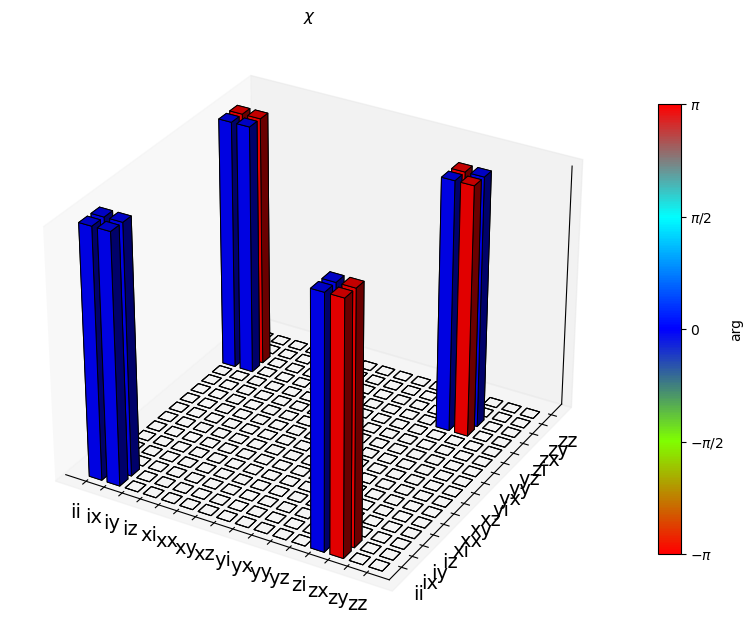

In [17]:
fig = plt.figure(figsize=(12, 6))

U_i_s = qt.to_super(U_target)

chi = qt.qpt(U_i_s, op_basis)

fig = qt.qpt_plot_combined(chi, op_label, fig=fig, threshold=0.001)

In [18]:
op_basis = [[qt.qeye(2), qt.sigmax(), qt.sigmay(), qt.sigmaz()]] * 2
op_label = [["i", "x", "y", "z"]] * 2

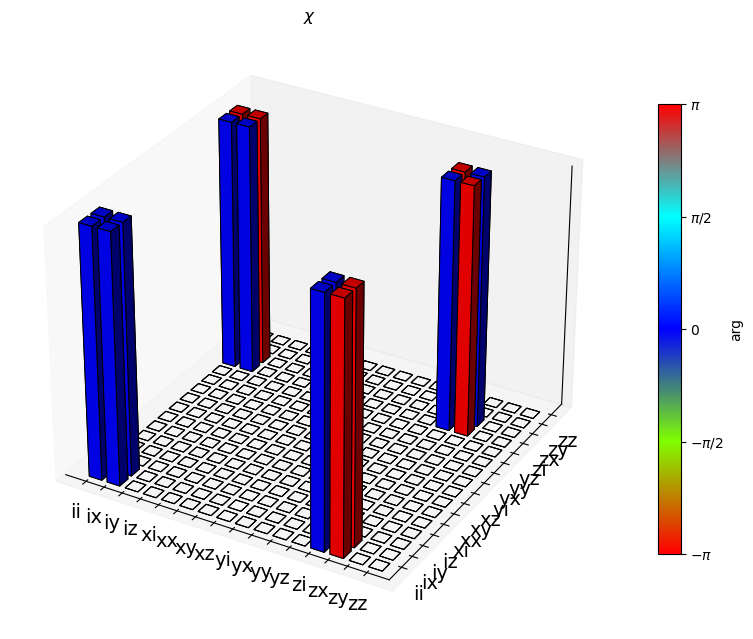

In [19]:
fig = plt.figure(figsize=(12, 6))

U_f_s = qt.to_super(U_f)

chi = qt.qpt(U_f_s, op_basis)

fig = qt.qpt_plot_combined(chi, op_label, fig=fig, threshold=0.01)

## Versions


In [20]:
qt.about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Simon Cross, Asier Galicia, Paul Menczel, and Patrick Hopf.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.3.0.dev0+6e4b53d
Numpy Version:      2.3.5
Scipy Version:      1.16.3
Cython Version:     3.2.2
Matplotlib Version: 3.10.8
Python Version:     3.12.0
Number of CPUs:     4
BLAS Info:          blas
INTEL MKL Ext:      None
Platform Info:      Linux (x86_64)
Installation path:  /home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip

Installed QuTiP family packages
-------------------------------

qutip-qtrl: 

qutip-jax: 0.1.1.dev6
qutip-qip: 0.5.0.dev0+81a92b9

Please cite QuTiP in your publication.
For your convenience a bibtex reference can be easily generated using `qutip.cite()`
